# Summary

ResPr-UNet-3D-Denoising-Efficient-Pipeline-TF-keras repository. This repository contains data, code and results for the paper, A residual U-Net network with image prior for 3D image denoising, Proc. Eur. Signal Process. Conf. EUSIPCO, pp. 1264-1268, 2020. (hal-02500664)  
   
Notebook for training 2D models for denoising. See Train_model_denoising2D.py. 

Data consists of a subsample of kits19 data, which can be directly downloaded from https://www.dropbox.com/sh/3sozaz9m7pyxcsa/AAAx1VULqc3T4rYC55vTiuJta?dl=0 (in png format, data with loosy conversion from float64 to unit8; fetch original data from [kits19](https://kits19.grand-challenge.org/)).

# Notebook settings

Demand GPU on Edit/Notebook settings.

# Define requirements and parameters

Requirements:

In [ ]:
# Requirements
import os
import pandas as pd
import numpy as np

import PIL
import PIL.Image
import pathlib
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import io
import random

print(tf.__version__)

2.5.0


The python code has been tested under Python 3.8 and tensorflow 2.4.1. 

Parameters for the model, training, image crop size, data augmentation, amount of aditive noise and for limiting the data size. It is also to continue training a previous model (*mode_continue_training*). 

In [ ]:
# Define parameters
#
# CNN
conv_model      = "UNet" # choose model: UNet, Convnet, ResNet
#
# Param for UNet and Convnet
conv_filt       = 32        # filters on first layer
kernel_size     = 3
activation      = "relu"
padding         = "same"
pool_size       = (2, 2)

# TRAIN
batch_size      = 64 # 4
epochs          = 5       # Early stopping on, check callbacks
optimizer       = "Adam"
learning_rate   = 1e-4      
validation_split = 0.1
train_eval_ratio = 0.9 

# Continue training a model from checkpoint
mode_continue_training = False
if mode_continue_training == True:
    path_previous_model = os.path.join(path_results,
                            "kits19_200subj_data2k_UNet_32_noisepc5_model_best.h5")    
    name_save = name_save + '_cont300it'

# Data augmentation
#
# central crop before applying random crop
central_fraction = 0.7 

# IMAGE
img_width, img_height, img_channels = (256,256,1) # (64,64,1)
input_shape     = (img_width, img_height, img_channels)

# Reduced randomly number of data slices
mode_limited_data = True
if mode_limited_data == True:
    ds_train_size   = 2000 # number slices in training set
ds_test_size    = 100

# Percentage of additive noise
perc_noise      = 0.05

Define function for simpler display and display training data:

# Data 

## Mount google drive and paths

Start by mounting your google drive:   

In [ ]:
# Mount google drive to access files via colab
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
# IMAGE VISUALIZATION
def displaySlices(X_Tensor, titles, figsize=(12,4), nameSave = []):
    # displaySlices(X_Tensor, titles)
    # displaySlices(X_Tensor, titles, figsize=(12,6), nameSave = 'name.png')
    #
    # Display slices (target, noisy image and prior)
    #
    # Inputs:
    #
    # X_Tensor = tuple of 2D arrays. 
    # X_Tensor =  (X_batch_train[0,:,:,0],S_batch_train[0,:,:,0],S_batch_pr_train[0,:,:,0])
    # titles    = ('Target','Noisy','Prior') 
    num_dim    = len(X_Tensor)
    fig, axarr = plt.subplots(1, num_dim, figsize=figsize)
    fig.tight_layout()    
    for i in range(num_dim):
        img0 = axarr[i].imshow(X_Tensor[i],cmap='gray')
        divider = make_axes_locatable(axarr[i])
        cax = divider.append_axes("right", size="7%", pad=0.05)
        plt.colorbar(img0, cax = cax) 
        axarr[i].set_title(titles[i])
        axarr[i].axis('off')
    plt.show()
    if nameSave:
        fig.savefig(nameSave, dpi = 300, bbox_inches='tight') 
    return fig

Define the path of the current notebook, something like /content/gdrive/MyDrive/Colab_Notebooks/3D_denosing/

In [ ]:
# path_main = os.getcwd()
path_notebook = "/content/gdrive/MyDrive/Colab_Notebooks/3D_denosing"
os.chdir(path_notebook)
print('Current directory: ' + os.getcwd())

## Download data

Download the data subset automatically into your drive to the same location of the notebook. Can comment after downloading first time (few minutes download). 

In [ ]:
# Comment after downlo!rm kits19_subset.zipading first time !
!wget -P path_notebook -O kits19_subset.zip https://www.dropbox.com/s/4i0ticxgmr452b5/Data.zip?dl=0
!unzip kits19_subset.zip
!rm kits19_subset.zip

## Data pipeline

**Tensorflow** data API is used to automatize the data pipeline, chaining transformations (preprocessing and data augmentation), shuffling data. 

Cache keeps the data in RAM memory after the first epoch (comment if not enough RAM is available; it must be ok for the sample data provided). Prefetch allows to prepare data for next batch while the model is being trained for the current batch on the GPU. Using tf datasets, data (image slices) are automatically fetched and pre-processed from the given directories.

On the tests carried out here, using .chache (keep images in memory) and .prefetch (fetch and prepare data for next iteration), iterations were 1.6 times faster.

First, we obtain a list with all slices in the training and test set folders (including all subfolders). 

In [ ]:
# PATHS 
subpath_data_train = os.path.join(path_notebook, "Data/Train")
subpath_data_test = os.path.join(path_notebook, "Data/Test")

# Create file list 
# 
# Train set
# tf.data.Dataset.from_tensor_slices with glob more efficient
data_dir_train = pathlib.Path(subpath_data_train) 
filenames_train = list(data_dir_train.glob('*/*.png'))
fnames_train = [str(fname) for fname in filenames_train]
print('Train sample slice ' + str(filenames_train[0]))
PIL.Image.open(str(filenames_train[0]))

# Test set
data_dir_test = pathlib.Path(subpath_data_test) 
filenames_test = list(data_dir_test.glob('*/*.png'))
fnames_test = [str(fname) for fname in filenames_test]

# Datasets ds train and test
if mode_limited_data == False:
    ds_train_size  = len(fnames_train)    
else:
    # Randomly select slices from the entire training set
    random.shuffle(fnames_train)


Create datasets from the lists of file names using ***from_tensor_slices*** for training, validation and test (splitting training data into train and eval sets). Then display few images using PIL. *from_tensor_slices* is more general than *list_files*, which appeared to be limited for the later operations. 

In [ ]:
# Train set
filelist_train_ds = tf.data.Dataset.from_tensor_slices(fnames_train[:ds_train_size]) 

# Check train ds: display images (can simply iterate over items in the data set)
# filelist_ds     = tf.data.Dataset.list_files(str(data_dir/'*/*'))
if 0:
  for a in filelist_train_ds.take(3):
      fname = a.numpy().decode("utf-8") # not in TF 1.4
      print(fname)
      display(PIL.Image.open(fname))

# Split train and eval 
ds_train = filelist_train_ds.take(int(ds_train_size*train_eval_ratio))
ds_eval = filelist_train_ds.skip(int(ds_train_size*train_eval_ratio))

print("Train data num: ", ds_train.cardinality().numpy())
print("Eval data num: ", ds_eval.cardinality().numpy())

# Test set
filelist_test_ds = tf.data.Dataset.from_tensor_slices(fnames_test[:ds_test_size])
ds_test = filelist_test_ds.take(ds_test_size)
print("Test data num: ", ds_test.cardinality().numpy())

Train data num:  1800
Eval data num:  192
Test data num:  100


Define data transformation pipeline: loading, processing (normalization, flip and random crop) and perturbating with additive Gaussian noise. First define the required functions and then apply the transformations.

In [ ]:
# Data Augmentation
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation
    Args:
        x: Image to flip
    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def random_crop(img):
    img = tf.image.central_crop(
        img, central_fraction)
    img = tf.image.random_crop(
            img, size=[img_height, img_width, 1])

    return img

# Additive noise
def add_gaussian_noise(img):
    #img_noisy = img + perc_noise*np.random.normal(0,1,img.shape)   
    img_noisy = img + perc_noise*tf.random.normal(img.shape,mean=0,stddev=1)
    return img_noisy
    
# Load and process image
def process_img(img):
    img = tf.image.decode_png(img, img_channels)
    
    # convert unit8 tensor to floats in range [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, [img_width, img_height])
    return img 

def get_process_target(file_path: tf.Tensor):
    img = tf.io.read_file(file_path)
    img = process_img(img)
    return img 

In [ ]:
# Transform data
# Load, normalize, data augmentation (random crop, horizontal flip), 
# corrupt with additive Gaussian noise 
map_ops     = [get_process_target, flip, random_crop] # Select data aug ops (flip, random_crop)

# TRAIN
for f in map_ops:
    ds_train = ds_train.map(lambda x: f(x),
        num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls for multithreading   
"""
for a in ds_train.take(2):
    plt.imshow(a.numpy()[:,:,0])
    plt.show() 
"""
ds_train = ds_train.map(  # return tuple (noisy, target) for training
        lambda x: (add_gaussian_noise(x), x),
        num_parallel_calls = tf.data.AUTOTUNE)
 
# EVAL
for f in map_ops:
    ds_eval = ds_eval.map(lambda x: f(x),
        num_parallel_calls=tf.data.AUTOTUNE)   
ds_eval = ds_eval.map(  
        lambda x: (add_gaussian_noise(x), x),
        num_parallel_calls = tf.data.AUTOTUNE)

# TEST    
for f in map_ops:
    ds_test = ds_test.map(lambda x: f(x),
        num_parallel_calls=tf.data.AUTOTUNE)   
ds_test = ds_test.map(  
        lambda x: (add_gaussian_noise(x), x),
        num_parallel_calls = tf.data.AUTOTUNE)

# Buffer size greater than or equal to the full size of the dataset 
buffer_size_train = ds_train.cardinality().numpy()
buffer_size_eval = ds_eval.cardinality().numpy()


Finalize pipeline by calling batch size, cache and prefetch: 

In [ ]:
# DS: .cache() keeps the images in memory after they're loaded off disk during 
# the first epoch. If dataset is too large (also use this method to create 
# a performant on-disk cache.
# .prefetch() overlaps data preprocessing and model execution while training
# To randomize iteration order, call shuffle after calling cache
# 
# Without .cache it is 23 % slower, and without .cache and .prefetch 64% slower
ds_train_batched = ds_train.batch(batch_size).cache()  # 
ds_train_batched = ds_train_batched.shuffle(buffer_size=buffer_size_train, 
                                            reshuffle_each_iteration=True,
                                            seed = 50)
ds_train_batched = ds_train_batched.prefetch(tf.data.experimental.AUTOTUNE)  
# 
ds_eval_batched = ds_eval.batch(batch_size).cache()
ds_eval_batched = ds_eval_batched.shuffle(buffer_size=buffer_size_eval, 
                                          reshuffle_each_iteration=True,
                                            seed = 50)
ds_eval_batched = ds_eval_batched.prefetch(tf.data.experimental.AUTOTUNE)  


Define the model: 

In [ ]:
# Simple 2D U-Net
def get_model_unet(input_shape = [28,28,1], 
                             conv_filt=32, 
                             kernel_size=3, 
                             activation="relu",
                             padding="same",
                             pool_size=pool_size):
    conv_args = {"activation": activation, 
                 "padding": padding,
                 "kernel_size": kernel_size}
    input_ = Input(shape=input_shape)
    conv1 = Conv2D(filters=conv_filt, **conv_args)(input_)
    conv2 = Conv2D(filters=conv_filt, **conv_args)(conv1)
    pool1 = MaxPool2D(pool_size=pool_size)(conv2)
    #
    conv3 = Conv2D(filters=2*conv_filt, **conv_args)(pool1)
    conv4 = Conv2D(filters=2*conv_filt, **conv_args)(conv3)
    pool2 = MaxPool2D(pool_size=pool_size)(conv4)
    #
    conv5 = Conv2D(filters=4*conv_filt, **conv_args)(pool2)
    conv6 = Conv2D(filters=2*conv_filt, **conv_args)(conv5)
    up1 = UpSampling2D(size=(2,2))(conv6)
    #
    conc1 = Concatenate()([conv4, up1])
    #
    conv7 = Conv2D(filters=2*conv_filt, **conv_args)(conc1)
    conv8 = Conv2D(filters=conv_filt, **conv_args)(conv7)
    up2 = UpSampling2D(size=(2,2))(conv8)
    #
    conc2 = Concatenate()([conv2, up2])
    #
    conv9 = Conv2D(filters=conv_filt, **conv_args)(conc2)
    conv10 = Conv2D(filters=conv_filt, **conv_args)(conv9)
    #
    output = Conv2D(filters=1, kernel_size=1, activation=None)(conv10)
    #
    model = keras.Model(inputs=[input_], outputs=[output])
    return model

Call the previous function to create the model or load a previous model to continue training. Define also the MSE loss, the optimizer (Adam), and metrics to be computed at every epoch. 

In [ ]:
if mode_continue_training == True:
    # Continue training a model from checkpoint
    #
    # Load previous model
    model = keras.models.load_model(path_previous_model) 
    
else:
    # Define model
    model   = get_model_unet(
        input_shape=input_shape, 
        conv_filt=conv_filt,
        kernel_size=kernel_size,
        activation=activation,
        padding=padding,
        pool_size=pool_size)

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)    
    model.compile(optimizer=optimizer,
              loss=loss_fn, 
              metrics=["mse"])         
         
model.summary()
# model.layers

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Train the model specifying the number of epochs, passing train and eval sets. Callbacks can be passed for saving a checkpoint (model), display results or save images, and for using Tensorboard. Metrics are saved in *history*.

The first epoch takes longer, as it is loading all training data (5 min), the following epochs take 20 s. 

In [ ]:
# TRAIN
#
# Fit the model
history = model.fit(ds_train_batched, 
                    epochs=epochs, 
                    validation_data=ds_eval_batched)#, 
                    #callbacks=callbacks)

Epoch 1/5
29/29 [==============================] - 75s 822ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 2/5
29/29 [==============================] - 21s 717ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/5
29/29 [==============================] - 21s 729ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 4/5
29/29 [==============================] - 21s 728ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 7.5662e-04 - val_mse: 7.5662e-04
Epoch 5/5
29/29 [==============================] - 21s 726ms/step - loss: 6.0411e-04 - mse: 6.0411e-04 - val_loss: 4.9679e-04 - val_mse: 4.9679e-04


Save the model in H5 format (default).

In [ ]:
# SAVE MODEL
path_results = os.path.join(path_notebook, 'Results')
if os.path.exists(path_results) is False: 
    os.mkdir(path_results)
name_save = 'Kits19_subset_UNet'
model.save(os.path.join(path_results, name_save + "_model_last.h5"))

Display training and evaluation losses. 

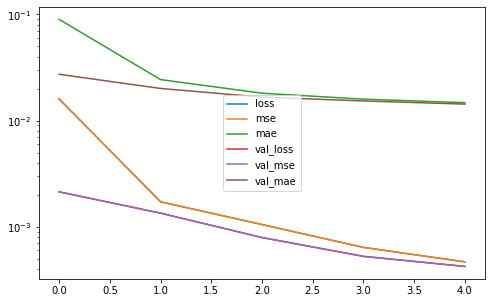

In [ ]:
# Losses
pd.DataFrame(history.history).plot(figsize=[8, 5], logy=True)
plt.show()

Load test data from test dataset. 

In [ ]:
# Load best model
#model = keras.models.load_model(os.path.join(path_results, 
#                                              name_save+'_model_last.h5'))                
def get_imgs_from_dataset(ds_test, ds_test_size):
    # Take images from data set ds_test: (data_test, data_test_noisy) 
    data_test = []
    data_test_noisy = []
    count = 0
    for a_n, a in ds_test.take(ds_test_size):
        data_test_this = a.numpy()  
        data_test_noisy_this = a_n.numpy() 
        if count == 0:
            data_test = data_test_this
            data_test_noisy = data_test_this
            count = 1
        else:            
            data_test = np.append(data_test, data_test_this, axis=2)
            data_test_noisy = np.append(data_test_noisy, data_test_noisy_this, axis=2)
    data_test = np.transpose(data_test, (2,0,1))
    data_test_noisy = np.transpose(data_test_noisy, (2,0,1))
    data_test = data_test[:,:,:,np.newaxis] 
    data_test_noisy = data_test_noisy[:,:,:,np.newaxis] 
    return data_test, data_test_noisy
    
# Test data
data_test, data_test_noisy = get_imgs_from_dataset(ds_test, ds_test_size)

Predit on test data (5 cropped samples), compute the error and display and save image.

Error 6.5
Example of restored images


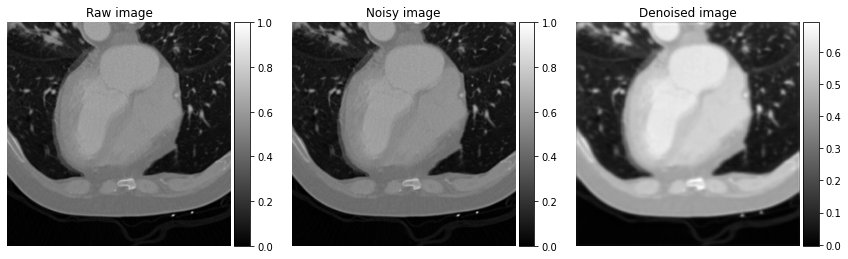

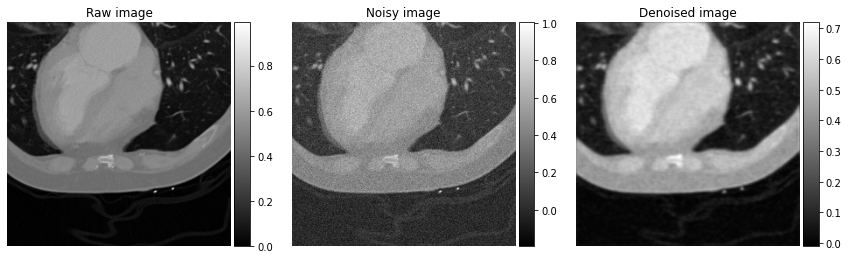

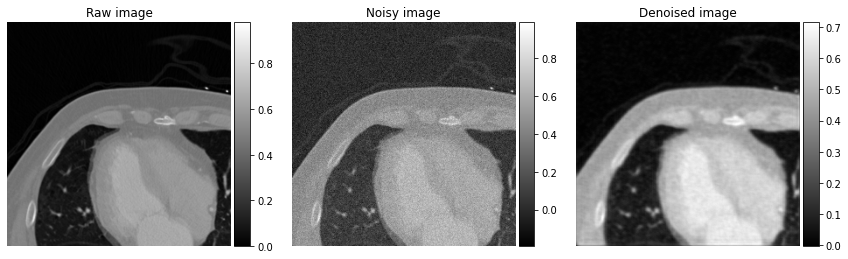

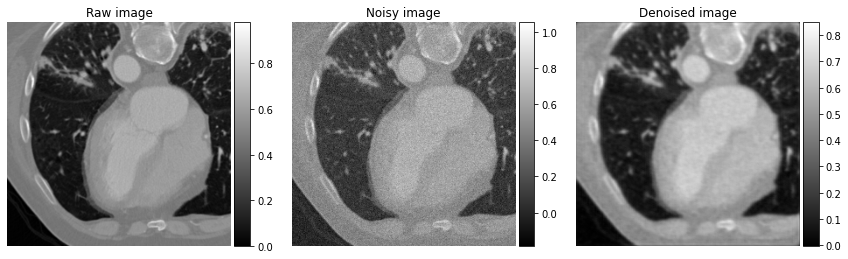

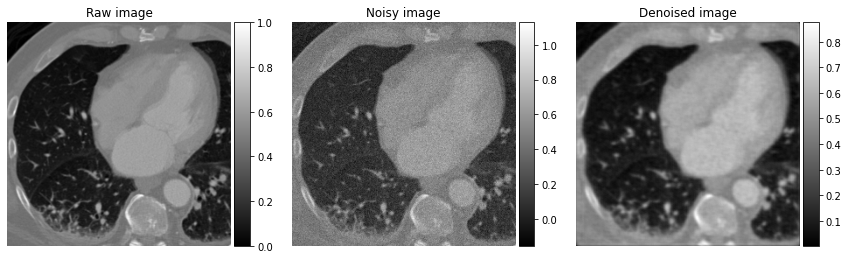

In [ ]:
# PREDICT AND ERROR
# 
# Predict (denoise image)
data_pred = model.predict(data_test_noisy)
data_pred_err = np.mean(100*np.linalg.norm(data_test[:,:,:,0]-
                data_pred[:,:,:,0], axis=(1, 2))/np.linalg.norm(data_test[:,:,:,0], axis=(1, 2)))
print('Error %.1f' % data_pred_err)

# Display result
print('Example of restored images')
for i in range(5):
    displaySlices([data_test[i,:,:,0], data_test_noisy[i,:,:,0], 
                   data_pred[i,:,:,0]], 
               ['Raw image', 'Noisy image', 'Denoised image'], 
               figsize=(12,4),
               nameSave=os.path.join(path_results,
                            name_save+'_test_ex'+str(i)+'.png'))


Increase the number of epochs to improve results or load a previously trained model for assessment. Models are provided in the repository. Copy trained model from the repository and place it in the Results folder (faster) or fetch it from the linnk below and save into your gdrive (takes few minutes).

In [ ]:
# Comment after download kits19_subset.zipading first time !
!wget -O Results/kits19_200subj_data2k_UNet_32_noisepc5_model_best.h5 https://www.dropbox.com/s/6j6h6b8mumz1a6l/kits19_200subj_data2k_UNet_32_noisepc5_model_best.h5?dl=0

In [ ]:
# Load best model
model = keras.models.load_model(os.path.join(path_results, 
                                              'kits19_200subj_data2k_UNet_32_noisepc5_model_best.h5'))                  

Predict and display with previously trained model: 

Error 3.5
Example of restored images


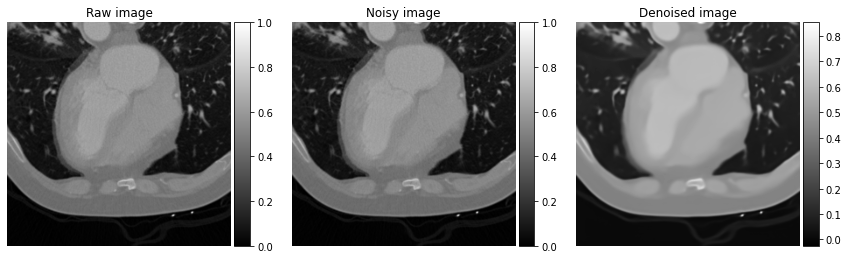

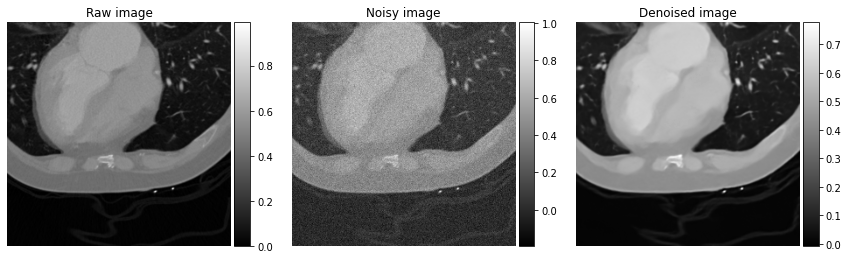

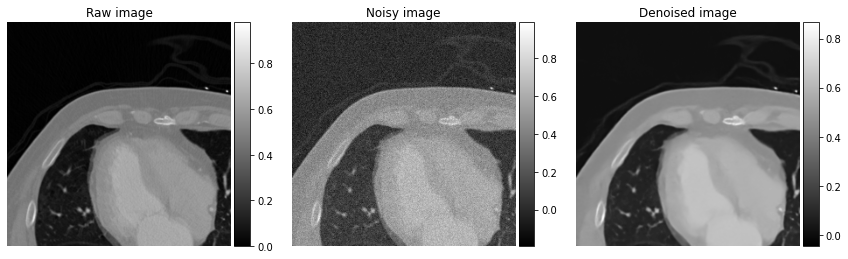

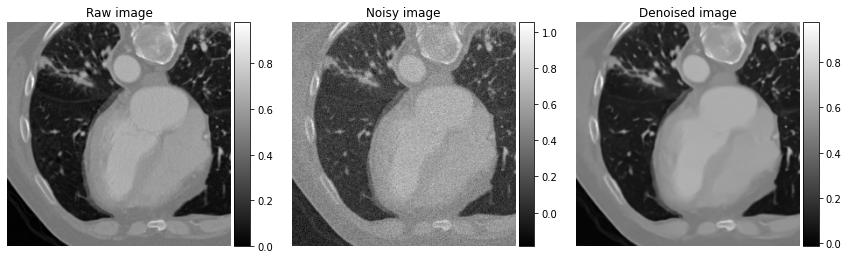

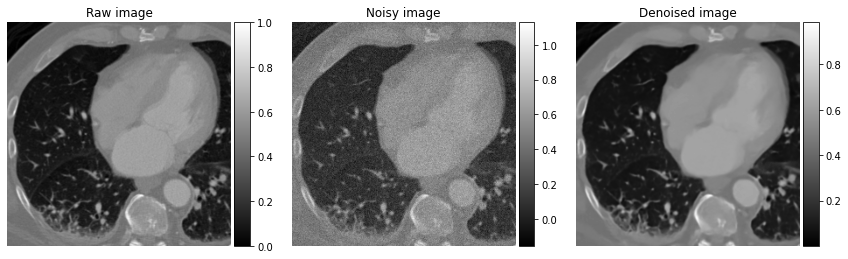

In [ ]:
# PREDICT AND ERROR
# 
# Predict (denoise image)
data_pred = model.predict(data_test_noisy)
data_pred_err = np.mean(100*np.linalg.norm(data_test[:,:,:,0]-
                data_pred[:,:,:,0], axis=(1, 2))/np.linalg.norm(data_test[:,:,:,0], axis=(1, 2)))
print('Error %.1f' % data_pred_err)

# Display result
print('Example of restored images')
for i in range(5):
    displaySlices([data_test[i,:,:,0], data_test_noisy[i,:,:,0], 
                   data_pred[i,:,:,0]], 
               ['Raw image', 'Noisy image', 'Denoised image'], 
               figsize=(12,4),
               nameSave=os.path.join(path_results,
                            name_save+'_test_ex'+str(i)+'.png'))